# 1.3 2-D Building  with custom source-Delta wavelet

### This notebook is a modfied version of '2d Buildin initial.ipynb' for loading a custom source time function (stf).
### Here we load the custom Delta wavelet.
#### ...........................................................................................................................................................................................
#### Initially edited by Salvus group of ETH (https://salvus.io/)
#### Modified by Yingjie Gao (gaoyingjie@mail.iggcas.ac.cn;gaoyingjie12@mails.ucas.ac.cn) 
#### Institute of Geology and Geophysics, Chinase Academy of Sciences, Beijing, China, 100029
#### ...........................................................................................................................................................................................

In [14]:
# Magic
# %autosave 0
%matplotlib inline
%config Completer.use_jedi = False

In [15]:
# Standard Python packages
import matplotlib.pyplot as plt
import numpy as np
import h5py

# Salvus packages
import salvus_flow.simple_config as config
import salvus_toolbox.toolbox as st
import salvus_toolbox.toolbox_geotech as st_geo
import salvus_flow.simple_config as sc
from salvus_flow import api

## Generating the mesh

In [4]:
n_stories = 50             # number of building stories
wall_width = 1.0           
story_height = 3.0
ceiling_height = 0.3
building_width = 20.0
basement_depth = 20.0
basement_width = 100.0

In [5]:
# f_max = 500.0
f_max = 10.0
# vs_min = 1500.0 
vs_min = 2000.0      # set the velocity manually below
# nelem_per_wavelength = 2.0
nelem_per_wavelength = 15.0

In [6]:
mesh, bnd = st_geo.get_simple_building(
    f_max=f_max,
    vs_min=vs_min,
    n_stories=n_stories,
    wall_width=wall_width,
    story_height=story_height,
    basement_width=basement_width,
    basement_depth=basement_depth,
    building_width=building_width,
    ceiling_height=ceiling_height,
    nelem_per_wavelength=nelem_per_wavelength,
)

In [7]:
nodes = mesh.get_element_nodes()[:, :, 0]
mesh.attach_field("RHO", np.ones_like(nodes) * 1000)
# mesh.attach_field("VS", np.ones_like(nodes) * vs_mi
# mesh.attach_field("VP", np.ones_like(nodes) * vs_min * 2)
mesh.attach_field("VS", np.ones_like(nodes) * 2000.0)      #S wave velocity for concrete: 2000 m/s
mesh.attach_field("VP", np.ones_like(nodes) * 3600.0)      #P wave velocity for concrete: 3600 m/s

#.................................................
# For heterogenous media (to make differenct velocities between the basement and the building)
y_centroids = mesh.get_element_centroid()[:, 1]
basement_elems = np.where(y_centroids < 0)
mesh.element_nodal_fields["VS"][basement_elems] = 1000.0    #S wave velocity for clay: 400-1000 m/s
mesh.element_nodal_fields["VP"][basement_elems] = 2000.0    #P wave velocity for clay: 1000-2500 m/s
#.................................................   

In [8]:
 mesh
#  help(mesh)   

In [9]:
# Write the mesh to a file which can be visualized in Paraview.
# Open the associated lambs_problem_mesh.xdmf to visualize.
# mesh.write_h5_tensorized_model("2D_building_mesh.h5")

## Setting up the simulation

## Insert custom source time function
according to https://salvus.io/examples/Jupytext/basics/custom_sources/custom_sources/

### There are two important things to notice:

    To avoid artifacts in the wavefield the custom source function should always start smoothly from zero to be compatible with the homogeneous initial conditions.

    You don't need to worry too much about the correct sampling rate, as the source time function will be resampled internally using the actual time step of the simulation. Just make sure that you have sufficiently many data points to avoid undersampling.

#### Setting the Custom source time function manually

600
1.0


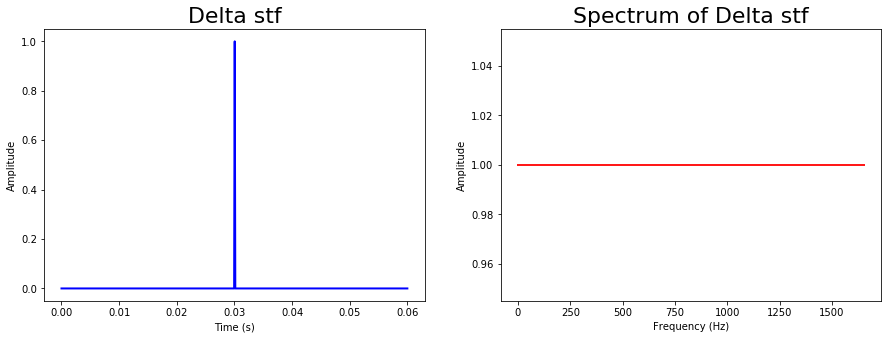

In [13]:
# Dleta wavelet
from scipy.fftpack import fft,ifft 
wavelet_width_in_seconds=0.03
time_step_in_seconds = 1e-4
dt=time_step_in_seconds
time = np.linspace(0,
                   2 * wavelet_width_in_seconds,
                   int((2 * wavelet_width_in_seconds / time_step_in_seconds)))

starttime_in_nanoseconds = 1e9 * time[0]
sampling_rate_in_hertz = 1.0 / time_step_in_seconds

(nt,)=np.shape(time)
print(nt)
A = np.zeros(nt)

import numpy
# print(numpy.argwhere(A == 0))
A[300]=1
print(A[300])
wavelet=A

f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Delta stf', fontsize=22)
ax[0].plot(time, wavelet, "b-", linewidth=2.0)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")

x=time

ff_Delta=fft(wavelet)
(nt,)=np.shape(x)
freq=1/dt/(nt*dt)*time

ax[1].set_title('Spectrum of Delta stf', fontsize=22)
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude")
ax[1].plot(freq[0:100],abs(ff_Delta)[0:100],color="red",linewidth=2.0,linestyle="-",alpha=0.9) 

### Custom Sources

In [19]:
#.................................................
# Custom source----Manually set stf  
sx, sy = -30.0, 0.0 # Source position (m)
fx, fy = 1.0, 1.0   # Source components (Nm)

source_time_function = np.array([fx * wavelet, fy * wavelet]).T
with  h5py.File('stf.h5','w') as f:
    dset = f.create_dataset('stf', data=source_time_function)
    dset.attrs['sampling_rate'] = sampling_rate_in_hertz
    dset.attrs['starttime'] = starttime_in_nanoseconds

stf = sc.source.stf.Custom(dataset_name='/stf', filename='stf.h5')
custom_source = sc.source.cartesian.VectorPoint2D(
    x=sx, y=sy, fx=fx, fy=fy,
    source_time_function=stf)
#.................................................

In [20]:
#n_rec = 100
#.................................................
n_rec = 4
#.................................................
x_rec = np.ones(n_rec) * -building_width / 2
y_rec = np.linspace(0, n_stories * story_height, n_rec)

receivers = [                                    
    config.receiver.cartesian.Point2D(          
        x=x,
        y=y,
        station_code=f"{_i:03d}",
        #fields=["velocity", "gradient-of-displacement","displacement","acceleration"],
        fields=[ "displacement","gradient-of-displacement","velocity","acceleration"],
    )
    for _i, (x, y) in enumerate(zip(x_rec, y_rec))
]                                                      
#.................................................

# `item` must be one of: "displacement", "velocity", "acceleration", 
# "gradient-of-displacement", "strain", "phi", "phi_t", "phi_tt", "gradient-of-phi"

In [22]:
# Initialize with sources and receivers.
w_custom = config.simulation.Waveform(mesh=mesh, sources=custom_source, receivers=receivers)

# w_custom = config.simulation.Waveform(mesh=mesh, sources=source, receivers=receivers)
# Set end time, start time is automatically determined.
w_custom.physics.wave_equation.end_time_in_seconds = 10.0             # total time 时间 unit: second

# Define and attach our absorbing boundaries.
ab = config.boundary.Absorbing(
    side_sets=["x0", "x1", "y0"], width_in_meters=bnd, taper_amplitude=f_max
)
w_custom.physics.wave_equation.boundaries = [ab]

# Use simplified HDF5 source output.
w_custom.output.point_data.format = "hdf5"

# Save the volumetric wavefield for visualization purposes.
# w.output.volume_data.format = "hdf5"
# w.output.volume_data.filename = "output.h5"
# w.output.volume_data.fields = ["displacement"]
# w.output.volume_data.sampling_interval_in_time_steps = 10

# Ensure that Salvus will accept our parameters.
w_custom.validate()

# Plot the mesh with the sources and receivers.
w_custom

## Running the simulation

### With the custom stf

In [24]:
api.run(
    ranks=4,
    get_all=True,
    input_file=w_custom,
    overwrite=True,
#     site_name="local",
    site_name="local_f64",  
# for low frequency wavelet, f64 version is essential to guarantee the accuracy, That is very important!
# salvus_f64 need be installed, and the site-name "local_f64" need be setted

   output_folder="output-custom-Delta-stf",     # You can set a folder location where you want to save the output files
)

# The local computer has limited storage, you can set the path of tht output files yourself
# such as an external hard disk.
# rec_file = "/media/ygao/Elements/salvus data/Delta reciever/receivers.h5"

Job `job_1910021648491146_490d78e257` running on `local_f64` with 4 rank(s).
Site information:
  * Salvus version: 0.10.1
  * Floating point size: 64



* Downloaded 26.1 MB of results to `output-custom-stf`.
* Total run time: 20.02 seconds.
* Pure simulation time: 18.61 seconds.


## Analyzing the results

In [16]:
# Read in data.
rec_file = "output-custom-Delta-stf/receivers.h5"
# rec_file = "/media/ygao/Elements/salvus data/Delta reciever/receivers.h5"
# field = "displacement"
field = "gradient-of-displacement"
uxx, dt, extent = st.get_shotgather(rec_file, field=field, cmp=0, axis=1) 
uxy, _, _ = st.get_shotgather(rec_file, field=field, cmp=1, axis=1)

print(dt)
print(np.shape(uxx))

nt,nx=np.shape(uxx)
nt
tt=np.linspace(0,(nt-1)*dt,nt)
nx=nx-1

1.16948942431e-05
(855075, 4)


In [20]:
from scipy.fftpack import fft,ifft 
import scipy.signal as signal

ff_uxy=fft(uxy[0:nt,3])
ff_uxx=fft(uxx[0:nt,3])

nt_taper=np.zeros(nt)
nt_taper[0:150]= 1.0

# hanning window
win_size = 100
# hann_window = signal.hanning(win_size)
hann_window = signal.windows.hann(win_size)

nt_taper[101:150]=hann_window[51:100]

ff_uxy=ff_uxy*nt_taper
ff_uxx=ff_uxx*nt_taper

uxy_f=np.real(ifft(ff_uxy))
uxx_f=np.real(ifft(ff_uxx))

Text(0.5, 0, 'Time (s)')

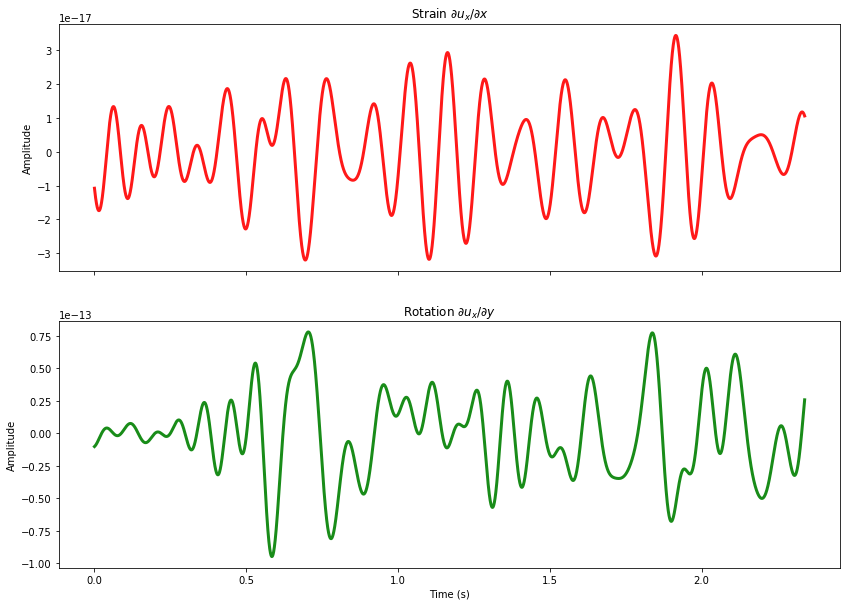

In [22]:
f, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the different fields.

ax[0].plot(tt[0:200000],uxx_f[0:200000],color="red",linewidth=3.0,linestyle="-",alpha=0.9) 
ax[1].plot(tt[0:200000],uxy_f[0:200000],color="green",linewidth=3.0,linestyle="-",alpha=0.9) 

# Label plots
ax[0].set_title(r"Strain $\partial u_x / \partial x$")
ax[1].set_title(r"Rotation $\partial u_x / \partial y$")

# Label axes.
ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Time (s)")
# plt.savefig('Comparison of waveforms by Delta wavelet.png')